In [1]:
import pathlib

import torch

import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler, DataLoader, random_split
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from neural_orientation_field.nerf.utils import cam_ray_from_pose
from neural_orientation_field.neof.dataset import NeOFImageDataset, NeOFRayDataset
from neural_orientation_field.neof.model import NeOFCoarseModel, NeOFFineModel
from neural_orientation_field.neof.utils import hair_dir_vec2color, static_volumetric_renderer, adaptive_volumetric_renderer, nerf_image_render

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Input
BODY_MASK_PATH = "../../data/images/blender-hair-long/body_mask/"
HAIR_MASK_PATH = "../../data/images/blender-hair-long/hair_mask/"
HAIR_DIR_PATH = "../../data/images/blender-hair-long/hair_dir/"
CAMERA_PATH = "../../data/cameras/blender-hair-long/"
CHECKPOINT_PATH = "../../data/models/neof/blender-hair-long/"

body_mask_path = pathlib.Path(BODY_MASK_PATH).resolve()
hair_mask_path = pathlib.Path(HAIR_MASK_PATH).resolve()
hair_dir_path = pathlib.Path(HAIR_DIR_PATH).resolve()
camera_path = pathlib.Path(CAMERA_PATH).resolve()
checkpoint_path = pathlib.Path(CHECKPOINT_PATH).resolve()
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

frame_name_path = camera_path / "frame-names.txt"
cam_transform_path = camera_path / "camera-transforms.npy"
cam_param_path = camera_path / "camera-params.npy"

body_mask_path, hair_mask_path, hair_dir_path, frame_name_path, cam_transform_path, cam_param_path, checkpoint_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/blender-hair-long/body_mask'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/blender-hair-long/hair_mask'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/blender-hair-long/hair_dir'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/cameras/blender-hair-long/frame-names.txt'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/cameras/blender-hair-long/camera-transforms.npy'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/cameras/blender-hair-long/camera-params.npy'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/models/neof/blender-hair-long'))

In [4]:
with open(frame_name_path, "r") as frame_path_file:
    frame_names = frame_path_file.read().split("\n")
    body_mask_paths = [body_mask_path / frame_name for frame_name in frame_names]
    hair_mask_paths = [hair_mask_path / frame_name for frame_name in frame_names]
    hair_dir_paths = [hair_dir_path / frame_name for frame_name in frame_names]
with open(cam_transform_path, "rb") as cam_transform_file:
    cam_transforms = np.load(cam_transform_file)
with open(cam_param_path, "rb") as cam_param_file:
    cam_params = np.load(cam_param_file)

In [5]:
# Validation set size
num_valid = 2

image_dataset = NeOFImageDataset(body_mask_paths, hair_mask_paths, hair_dir_paths, cam_params, cam_transforms)
num_train = len(image_dataset) - num_valid
image_dataset_train, image_dataset_valid = random_split(image_dataset, [num_train, num_valid])
len(image_dataset_train), len(image_dataset_valid)

(126, 2)

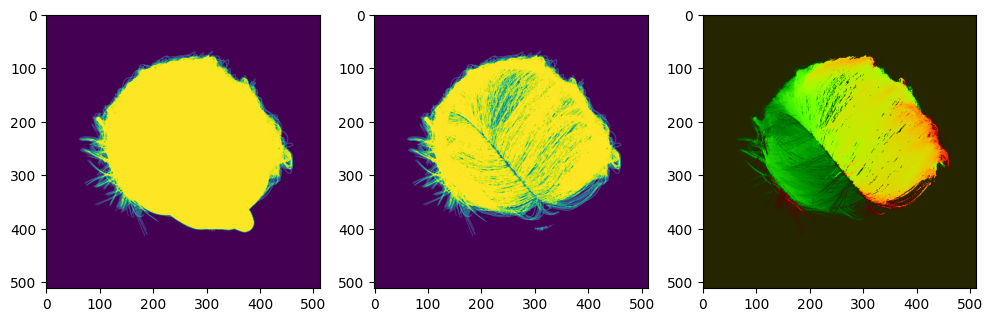

In [6]:
(bm, hm, hd), cam_trans, (h, w), (f, cx, cy) = image_dataset[0]

fig, (ax_bm, ax_hm, ax_hd) = plt.subplots(1, 3, figsize=(12, 4))

ax_bm.imshow(bm)
ax_hm.imshow(hm)
ax_hd.imshow(hair_dir_vec2color(hd))

In [7]:
with tqdm(total=len(image_dataset_train), desc="Processing Image") as progress:
    ray_dataset = NeOFRayDataset(image_dataset_train, progress)

Processing Image:   0%|          | 0/126 [00:00<?, ?it/s]

# NeOF

In [8]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

## NeOF Training

In [9]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
coarse_pos_encode = 2
fine_pos_encode = 4
samples_per_ray = 4
max_subd_samples = 4
# Hyper parameters.
lr = 2e-4
num_epochs = 1
ray_batch_size = 8192
# Training settings.
size_train_ray = 1
valid_per_epoch = 8

In [10]:
# Init model.
coarse_model = NeOFCoarseModel(num_encoding_functions=coarse_pos_encode)
coarse_model.to(device)
coarse_optimizer = torch.optim.Adam(coarse_model.parameters(), lr=lr)

fine_model = NeOFFineModel(num_encoding_functions=fine_pos_encode)
fine_model.to(device)
fine_optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

In [ ]:
coarse_model.train()
fine_model.train()

train_sampler = RandomSampler(data_source=ray_dataset, num_samples=int(size_train_ray * len(ray_dataset)))
dataloader = DataLoader(
    ray_dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

model_params = {
    "coarse_pos_encode": coarse_pos_encode,
    "fine_pos_encode": fine_pos_encode,
    "nc": nc,
    "fc": fc,
    "samples_per_ray": samples_per_ray,
    "max_subd_samples": max_subd_samples,
}
torch.save(model_params, checkpoint_path / f"model_params.pth")

writer = SummaryWriter(flush_secs=1)
valid_hair_dirs = []
for (_, _, valid_hair_dir), _, _, _ in image_dataset_valid:
    valid_hair_dirs.append(hair_dir_vec2color(valid_hair_dir))
valid_hair_dirs = np.array(valid_hair_dirs)
writer.add_image("Valid Hair Direction Ground Truth", valid_hair_dirs, dataformats="NHWC")

best_loss = float("inf")
best_model_coarse = None
best_model_fine = None

for epoch in tqdm(range(num_epochs)):
    valid_every_n_batch = int(len(dataloader) / valid_per_epoch)
    # One iteration of the training.
    for batch_i, (
        cam_trans_batch,
        cam_orig_batch,
        cam_ray_batch,
        body_mask_batch,
        hair_mask_batch,
        hair_dir_batch
    ) in enumerate(tqdm(dataloader)):
        cam_trans_batch = cam_trans_batch.type(torch.float32).to(device)
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        body_mask_batch = body_mask_batch.type(torch.float32).to(device)
        hair_dir_batch = hair_dir_batch.type(torch.float32).to(device)
        hair_mask_batch = hair_mask_batch.type(torch.float32).to(device)
        coarse_ss_orientation, coarse_occupancy, sample_depth = static_volumetric_renderer(
            coarse_model,
            cam_trans_batch.reshape(-1, 4, 4),
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=coarse_pos_encode,
            device=device
        )
        coarse_body_occupancy = 1 - coarse_occupancy[:, :, -1]
        coarse_loss = torch.nn.functional.mse_loss(coarse_ss_orientation, hair_dir_batch)
        fine_ss_orientation, fine_occupancy, _ = adaptive_volumetric_renderer(
            fine_model,
            cam_trans_batch.reshape(-1, 4, 4),
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            coarse_body_occupancy,
            sample_depth,
            max_subd_sample=max_subd_samples,
            num_pos_encode=fine_pos_encode,
            device=device
        )
        fine_loss = torch.nn.functional.mse_loss(fine_ss_orientation, hair_dir_batch)
        loss = coarse_loss + fine_loss
        loss.backward()
        coarse_optimizer.step()
        coarse_optimizer.zero_grad()
        fine_optimizer.step()
        fine_optimizer.zero_grad()
        writer.add_scalar("Coarse Loss Train", coarse_loss,
                          (epoch * len(dataloader) + batch_i) * ray_batch_size)
        writer.add_scalar("Fine Loss Train", fine_loss,
                          (epoch * len(dataloader) + batch_i) * ray_batch_size)

        if batch_i % valid_every_n_batch == 0:
            coarse_model.eval()
            fine_model.eval()

            coarse_preds = []
            fine_preds = []
            coarse_losses = []
            fine_losses = []
            for (_, _, valid_hair_dir), cam_transform, (h, w), (f, cx, cy) in image_dataset_valid:
                cam_orig, cam_ray_world = cam_ray_from_pose(
                    cam_transform, h, w, f, cx, cy)
                coarse_pred, fine_pred = nerf_image_render(
                    coarse_model,
                    fine_model,
                    cam_transform,
                    cam_orig,
                    cam_ray_world,
                    ray_batch_size,
                    nc,
                    fc,
                    samples_per_ray,
                    max_subd_samples,
                    coarse_pos_encode,
                    fine_pos_encode,
                    device
                )
                coarse_preds.append(hair_dir_vec2color(coarse_pred))
                fine_preds.append(hair_dir_vec2color(fine_pred))
                valid_hair_dir = torch.tensor(valid_hair_dir)
                coarse_loss = torch.nn.functional.mse_loss(
                    coarse_pred, valid_hair_dir)
                fine_loss = torch.nn.functional.mse_loss(
                    fine_pred, valid_hair_dir)
                coarse_losses.append(coarse_loss)
                fine_losses.append(fine_loss)

            coarse_preds = np.array(coarse_preds)
            fine_preds = np.array(fine_preds)
            coarse_loss_valid = np.array(coarse_losses).mean()
            fine_loss_valid = np.array(fine_losses).mean()
            loss_valid = coarse_loss_valid + fine_loss_valid
            if loss_valid < best_loss:
                best_model_coarse = coarse_model.state_dict()
                best_model_fine = fine_model.state_dict()
                best_loss = loss_valid
            writer.add_scalar("Coarse Loss Valid", coarse_loss_valid,
                              (epoch * len(dataloader) + batch_i) * ray_batch_size)
            writer.add_scalar("Fine Loss Valid", fine_loss_valid,
                              (epoch * len(dataloader) + batch_i) * ray_batch_size)
            writer.add_image("Rendered Validation Image Coarse", coarse_preds, (epoch *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="NHWC")
            writer.add_image("Rendered Validation Image Fine", fine_preds, (epoch *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="NHWC")
            coarse_model.train()
            fine_model.train()

    torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_epoch_{epoch}.pth")
    torch.save(fine_model.state_dict(), checkpoint_path / f"fine_epoch_{epoch}.pth")
writer.close()

if best_model_coarse:
    coarse_model.load_state_dict(best_model_coarse)
if best_model_fine:
    fine_model.load_state_dict(best_model_fine)

torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_final.pth")
torch.save(fine_model.state_dict(), checkpoint_path / f"fine_final.pth")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4032 [00:00<?, ?it/s]